In [119]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(r'..\..\data\vgg_face\vgg_face_weights.h5')

In [2]:
# face verification with the VGGFace2 model
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
# from keras_vggface.vggface import VGGFace
# from keras_vggface.utils import preprocess_input
import pandas as pd

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
    # load image from file
#     pixels = pyplot.imread(filename)
#     # create the detector, using default weights
#     detector = MTCNN()
#     # detect faces in the image
#     results = detector.detect_faces(pixels)
#     # extract the bounding box from the first face
#     x1, y1, width, height = results[0]['box']
#     x2, y2 = x1 + width, y1 + height
#     # extract the face
#     face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.open(filename)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

def prepare_file(filename):
    img=load_img(filename, target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

def get_embeddings(filenames):
    samples = [prepare_file(f) for f in filenames]
    global model
    return [np.squeeze(K.eval(model(s))).tolist() for s in samples]

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
        return True, score
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
        return False, score

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

In [4]:
BASE_PATH = pathlib.Path('../../data/mfr2')
labels_path = BASE_PATH / 'mfr2_labels.txt'
pairs_path = BASE_PATH / 'pairs.txt'

In [5]:
labels=pd.read_csv(filepath_or_buffer=str(labels_path))
labels=labels.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)
people=labels["person"].unique()

def get_indexes(person, mask=True):
    if mask:
        mask_filter = labels["mask"]!="no-mask"
    else:
        mask_filter = labels["mask"]=="no-mask"
    person_filter = labels["person"]==person
    return list(labels[person_filter & mask_filter]["index"])

total_pairs={person:list(zip(get_indexes(person,mask=True), get_indexes(person, mask=False))) for person in people}

In [64]:
person, pairs = list(total_pairs.items())[0]
index1, index2 = pairs[0]
path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'

features1,features2=get_embeddings([path1, path2])
#print(features1.shape)
#print(np.squeeze(K.eval(features1)).shape)
matched, distance = is_match(features1, features2)

>face is NOT a Match (0.828 > 0.500)


In [7]:
data = []

In [8]:
results = []

# positive test
for person, pairs in total_pairs.items():
    for index1, index2 in pairs:
        path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'

        features1,features2=get_embeddings([path1, path2])
        matched, distance = is_match(features1, features2)
        data.append(([features1, features2], 1))
        results.append([(person, index1, index2), matched, distance])

>face is NOT a Match (0.828 > 0.500)
>face is NOT a Match (0.806 > 0.500)
>face is NOT a Match (0.960 > 0.500)
>face is NOT a Match (0.919 > 0.500)
>face is NOT a Match (0.720 > 0.500)
>face is NOT a Match (0.765 > 0.500)
>face is NOT a Match (0.996 > 0.500)
>face is NOT a Match (0.959 > 0.500)
>face is NOT a Match (0.964 > 0.500)
>face is NOT a Match (0.784 > 0.500)
>face is NOT a Match (0.829 > 0.500)
>face is NOT a Match (0.985 > 0.500)
>face is NOT a Match (0.588 > 0.500)
>face is NOT a Match (0.502 > 0.500)
>face is NOT a Match (0.984 > 0.500)
>face is NOT a Match (0.758 > 0.500)
>face is NOT a Match (0.571 > 0.500)
>face is NOT a Match (0.758 > 0.500)
>face is NOT a Match (0.777 > 0.500)
>face is a Match (0.477 <= 0.500)
>face is NOT a Match (0.735 > 0.500)
>face is NOT a Match (0.674 > 0.500)
>face is NOT a Match (0.594 > 0.500)
>face is NOT a Match (0.861 > 0.500)
>face is NOT a Match (0.549 > 0.500)
>face is NOT a Match (0.885 > 0.500)
>face is NOT a Match (0.646 > 0.500)
>fac

In [9]:
# results = []

# # positive test
# for pair in pairs:
#     (person1,index1),(person2,index2) = pair
#     path1 = BASE_PATH / person1 / f'{person1}_{str(index1).rjust(4, "0")}.png'
#     path2 = BASE_PATH / person2 / f'{person2}_{str(index2).rjust(4, "0")}.png'
    
# #     try:
#     features1,features2=get_embeddings([path1, path2])
#     matched, distance = is_match(features1, features2)
# #     except Exception as e:
# #         print(e)
# #         continue
    
#     results.append([pair, matched, distance])

In [10]:
TP=len([x for x in results if x[1]]) / len(results)
FN=1-TP

In [11]:
TP

0.06593406593406594

In [12]:
FN

0.9340659340659341

In [13]:
len(list(BASE_PATH.iterdir()))

55

In [14]:
import random
results_neg = []
count = 0

for person1 in BASE_PATH.iterdir():
    random_people = list(BASE_PATH.iterdir())
    random.shuffle(random_people)
    i=0
    for person2 in random_people:
        if not person1.is_dir() or not person2.is_dir() or person1.name == person2.name or not person1.name.isalpha() or not person2.name.isalpha():
            continue
        count += 1
        if count >= len(results):
            break
        index1 = index2 = 1
        
        path1 = BASE_PATH / person1.name / f'{person1.name}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person2.name / f'{person2.name}_{str(index2).rjust(4, "0")}.png'

        try:
            features1,features2=get_embeddings([path1, path2])
            matched, distance = is_match(features1, features2)
        except Exception as e:
            print(e)
            continue
        data.append(([features1,features2], 0))
        results_neg.append([(person1, person2), matched, distance])
        i+=1
        if i == 2:
            break

>face is NOT a Match (0.986 > 0.500)
>face is NOT a Match (0.938 > 0.500)
>face is NOT a Match (0.800 > 0.500)
>face is NOT a Match (0.984 > 0.500)
>face is NOT a Match (0.922 > 0.500)
>face is NOT a Match (0.986 > 0.500)
>face is NOT a Match (0.843 > 0.500)
>face is NOT a Match (0.993 > 0.500)
>face is NOT a Match (0.937 > 0.500)
>face is NOT a Match (0.931 > 0.500)
>face is NOT a Match (0.987 > 0.500)
>face is NOT a Match (0.969 > 0.500)
>face is NOT a Match (1.000 > 0.500)
>face is NOT a Match (0.983 > 0.500)
>face is NOT a Match (0.766 > 0.500)
>face is NOT a Match (0.912 > 0.500)
>face is NOT a Match (0.970 > 0.500)
>face is NOT a Match (0.969 > 0.500)
>face is NOT a Match (0.656 > 0.500)
>face is NOT a Match (0.644 > 0.500)
>face is NOT a Match (0.906 > 0.500)
>face is NOT a Match (0.982 > 0.500)
>face is NOT a Match (0.736 > 0.500)
>face is NOT a Match (0.941 > 0.500)
>face is NOT a Match (0.864 > 0.500)
>face is NOT a Match (0.936 > 0.500)
>face is NOT a Match (0.988 > 0.500)
>

In [15]:
import random
random.shuffle(data)

In [16]:
len(data)*70//100

126

In [17]:
train = data[:len(data)*70//100]
test = data[len(data)*70//100:]
validation = train[len(train)*90//100:]
train = train[:len(train)*90//100]

test_data = np.asarray([np.squeeze(np.asarray(t).flatten()) for t,l in test])
test_labels = np.asarray([l for t,l in test])
train_data = np.asarray([np.squeeze(np.asarray(t).flatten()) for t,l in train])
train_labels = np.asarray([l for t,l in train])
validation_data = np.asarray([np.squeeze(np.asarray(t).flatten()) for t,l in validation])
validation_labels = np.asarray([l for t,l in validation])

In [18]:
(test_data[0].shape, np.squeeze(test_data[0].flatten()).shape,
train_data[0].shape, np.squeeze(train_data[0].flatten()).shape)

((5244,), (5244,), (5244,), (5244,))

In [19]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
#classifier_model.add(Flatten(input_shape=train_data.shape[1:]))
classifier_model.add(Dense(units=100,input_dim=2622*2,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=2,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

In [20]:
classifier_model.fit(train_data, train_labels, epochs=50, batch_size=16, validation_data=(validation_data, validation_labels))

Epoch 1/50
8/8 [==============================] - 1s 34ms/step - loss: 0.9859 - accuracy: 0.5133 - val_loss: 0.6879 - val_accuracy: 0.8462
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.4686 - accuracy: 0.7965 - val_loss: 0.6854 - val_accuracy: 0.6923
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3643 - accuracy: 0.8761 - val_loss: 0.6842 - val_accuracy: 0.6154
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3136 - accuracy: 0.9027 - val_loss: 0.6854 - val_accuracy: 0.6154
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1922 - accuracy: 0.9469 - val_loss: 0.6818 - val_accuracy: 0.7692
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.1838 - accuracy: 0.9469 - val_loss: 0.6760 - val_accuracy: 0.8462
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1245 - accuracy: 0.9823 - val_loss: 0.6752 - val_accuracy: 0.8462
Epoch 8/50
8/8 [============

In [21]:
#classifier_model.save_weights(r'classifier_weights.h5')

In [22]:
x_results = []
for d,l in zip(test_data, test_labels):
    x_results+=[(classifier_model.predict([np.squeeze(d.flatten()).reshape(1,-1)]), l)]

In [23]:
#x_results[0],np.argmax(x_results[0][0])
len([1 for p,l in x_results if np.argmax(p)==l]) / len(x_results)

0.6909090909090909

In [11]:
TP=len([x for x in x_results if x[1] and np.argmax(x[0])==1]) / (len(x_results))
FN=len([x for x in x_results if not x[1] and np.argmax(x[0])==1]) / (len(x_results))
FP=len([x for x in x_results if x[1] and np.argmax(x[0])==0]) / (len(x_results))
TN=len([x for x in x_results if not x[1] and np.argmax(x[0])==0]) / (len(x_results))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TP,FN],
         [FP,TN]]

df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

NameError: name 'x_results' is not defined

In [25]:
# from sklearn import svm
# X = [x[2] for x in results] + [x[2] for x in results_neg]
# y = [1 for x in results] + [0 for x in results_neg]
# clf = svm.SVC() #kernel="linear")
# clf.fit(np.array(X).reshape(-1, 1), y)

In [26]:
# ps=clf.predict(np.array([x[2] for x in results]).reshape(-1, 1))

In [27]:
# len([x for x in ps if x == 1])

In [28]:
# ns=clf.predict(np.array([x[2] for x in results_neg]).reshape(-1, 1))

In [29]:
# np.array([x[2] for x in results + results_neg])

In [30]:
# len([x for x in ps if x == 0])

In [31]:
# len(ps)

In [32]:
# TP=len([x for x in ps if x]) / (len(results) + len(results_neg))
# FN=len([x for x in ps if not x]) / (len(results) + len(results_neg))
# FP=len([x for x in ns if x]) / (len(results) + len(results_neg))
# TN=len([x for x in ns if not x]) / (len(results) + len(results_neg))
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt

# array = [[TP,FN],
#          [FP,TN]]

# df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# # plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

# plt.show()

In [33]:
import seaborn as sns

<AxesSubplot:xlabel='distance', ylabel='Percent'>

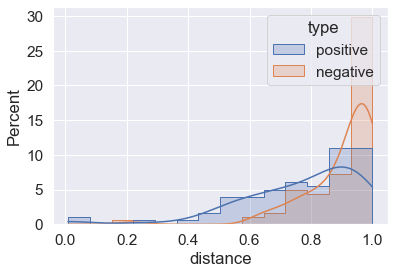

In [34]:
total_results = pd.DataFrame(data=[(x[2],"positive") for x in results]+[(x[2],"negative") for x in results_neg], columns=["distance", "type"])
sns.histplot(total_results, x='distance', hue='type', element='step', kde=True, stat='percent')

<AxesSubplot:xlabel='distance', ylabel='Percent'>

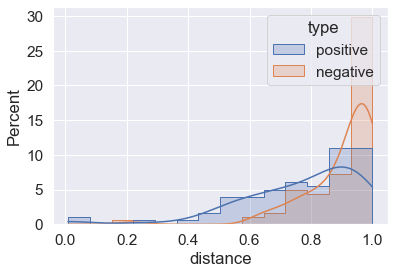

In [35]:
total_results = pd.DataFrame(data=[(x[2],"positive") for x in results]+[(x[2],"negative") for x in results_neg], columns=["distance", "type"])
sns.histplot(total_results, x='distance', hue='type', element='step', kde=True, stat='percent')

In [36]:
test_labels[0]

1

In [37]:
import shap
background = test_data[0]
# person, pairs = list(total_pairs.items())[0]
# index1, index2 = pairs[0]
# path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
# path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'

# sample1, sample2 = prepare_file([path1, path2])

In [38]:
test_data.shape, background.shape

((55, 5244), (5244,))

In [39]:
bg = np.array([background])
bg.shape

(1, 5244)

In [40]:
# bg.reshape(1,-1).shape, np.asarray(shap_values[0]).reshape(1,-1).shape

In [41]:
e = shap.GradientExplainer(classifier_model, test_data)
shap_values = e.shap_values(test_data)
# shap.image_plot(shap_values[0][0], bg[0])

# features1,features2=get_embeddings([path1, path2])
# matched, distance = is_match(features1, features2)
# results.append([(person, index1, index2), matched, distance])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [42]:
np.array(shap_values).shape

(2, 55, 5244)

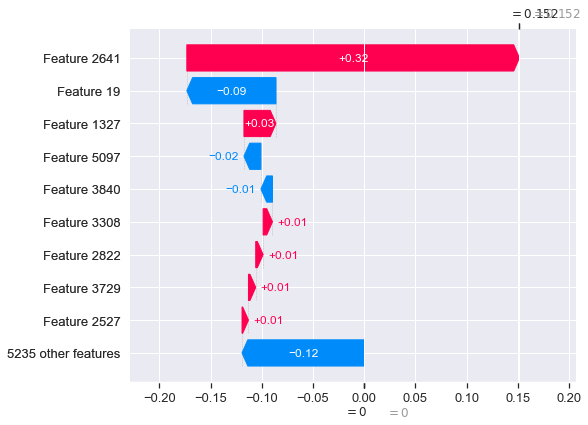

In [43]:
shap.plots._waterfall.waterfall_legacy(0, shap_values[0][0])

In [44]:
# shap.initjs()
# shap.plots.force(0, shap_values[0]) too much

In [128]:
model_imgs = []
original_paths = []

# positive test
for person, pairs in total_pairs.items():
    for index1, index2 in pairs:
        path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'
        img1=prepare_file(path1)
        model_imgs.append(img1)
        original_paths.append(path1)
# model_imgs = np.squeeze(np.array(model_imgs))
# e2 = shap.GradientExplainer(model, model_imgs)
# shap_values = e2.shap_values(model_imgs[0])
# shap.image_plot(shap_values[0][0], bg[0])

In [46]:
# # explain how the input to the 7th layer of the model explains the top two classes
# def map2layer(x, layer):
#     feed_dict = {model.layers[0].input:x}
#     return K.get_session().run(model.layers[layer].input, feed_dict)

# e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output),
#                            map2layer(model_imgs.copy(), 9))

# shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# # get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# # plot the explanations
# shap.image_plot(shap_values, to_explain, index_names)

In [47]:
# # explain predictions of the model on four images
# e = shap.DeepExplainer(model, np.array([model_imgs[0]]))
# # ...or pass tensors directly
# # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(np.array([model_imgs[0]]))

# # plot the feature attributions
# shap.image_plot(shap_values, -model_imgs[0])

In [48]:
# model_imgs[0][1].shape

In [49]:
# model_imgs[0].reshape(224,224,3)

In [50]:
# e.shap_values?

In [105]:
blocks = []
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'pool' not in layer.name:
        continue
    # summarize output shape
    for j in range(5):
        conv = i+j+1
        if 'conv' in model.layers[conv].name:
            break
    else:
        continue
        
    print(i, layer.name, layer.output.shape,'->',conv, model.layers[conv].name, model.layers[conv].output.shape)
    blocks.append(conv)
blocks.pop(-1)

4 max_pooling2d (None, 112, 112, 64) -> 6 conv2d_2 (None, 112, 112, 128)
9 max_pooling2d_1 (None, 56, 56, 128) -> 11 conv2d_4 (None, 56, 56, 256)
16 max_pooling2d_2 (None, 28, 28, 256) -> 18 conv2d_7 (None, 28, 28, 512)
23 max_pooling2d_3 (None, 14, 14, 512) -> 25 conv2d_10 (None, 14, 14, 512)
30 max_pooling2d_4 (None, 7, 7, 512) -> 31 conv2d_13 (None, 1, 1, 4096)


31

In [52]:
xmodel = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [80]:
feature_maps = xmodel.predict(model_imgs[2])

In [81]:
feature_maps.shape

(1, 224, 224, 64)

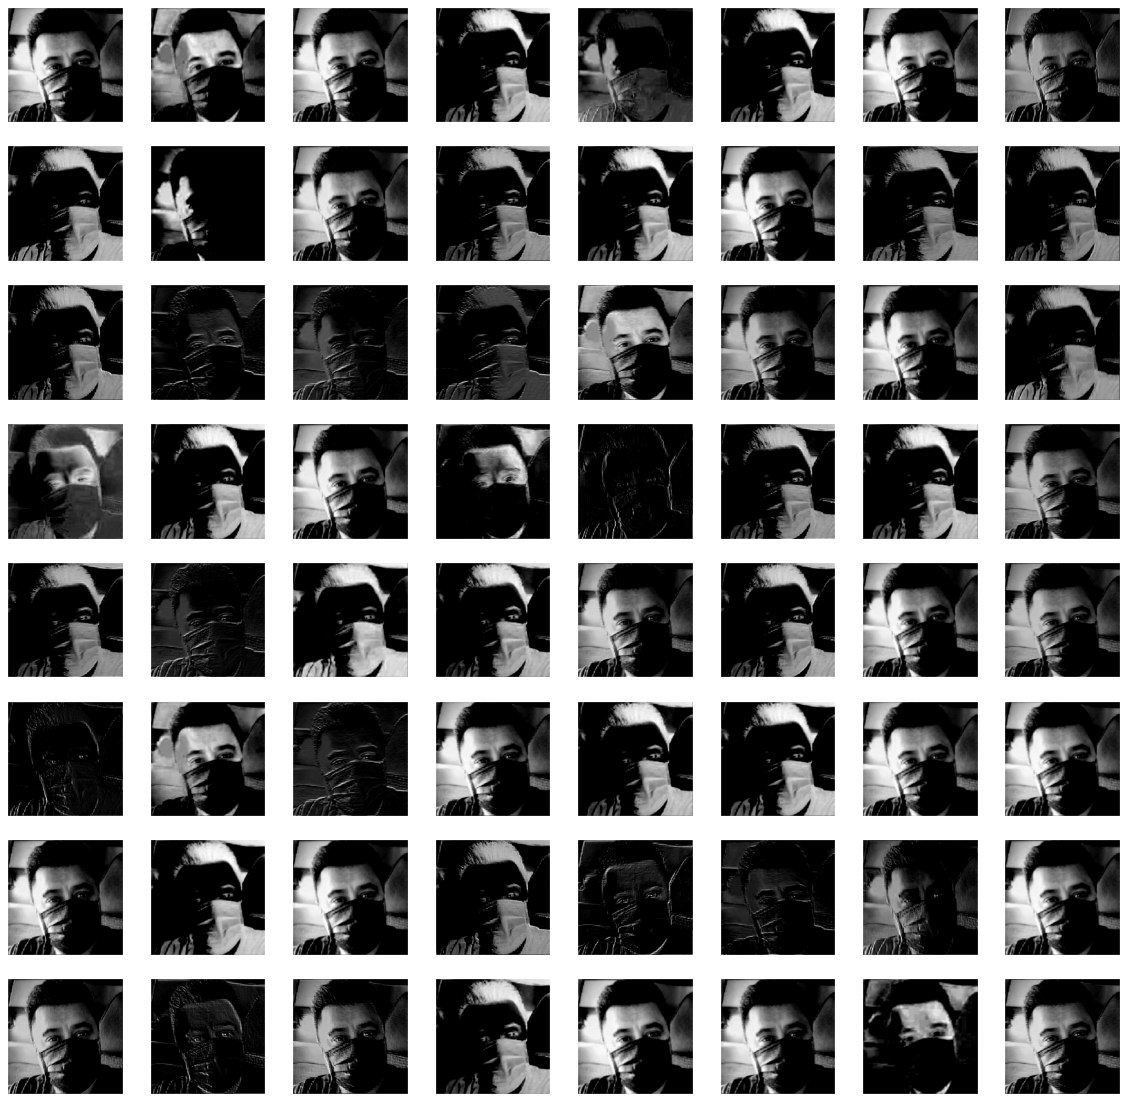

In [82]:
square = 8
ix = 1
plt.figure(figsize = (20,20))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

In [78]:
feature_maps.shape

(1, 224, 224, 64)

In [97]:
outputs = [model.layers[i].output for i in blocks]
xmodel = Model(inputs=model.inputs, outputs=outputs)
feature_maps = xmodel.predict(model_imgs[2])

In [98]:
[m.shape for m in feature_maps]

[(1, 112, 112, 128),
 (1, 56, 56, 256),
 (1, 28, 28, 512),
 (1, 14, 14, 512),
 (1, 1, 1, 4096)]

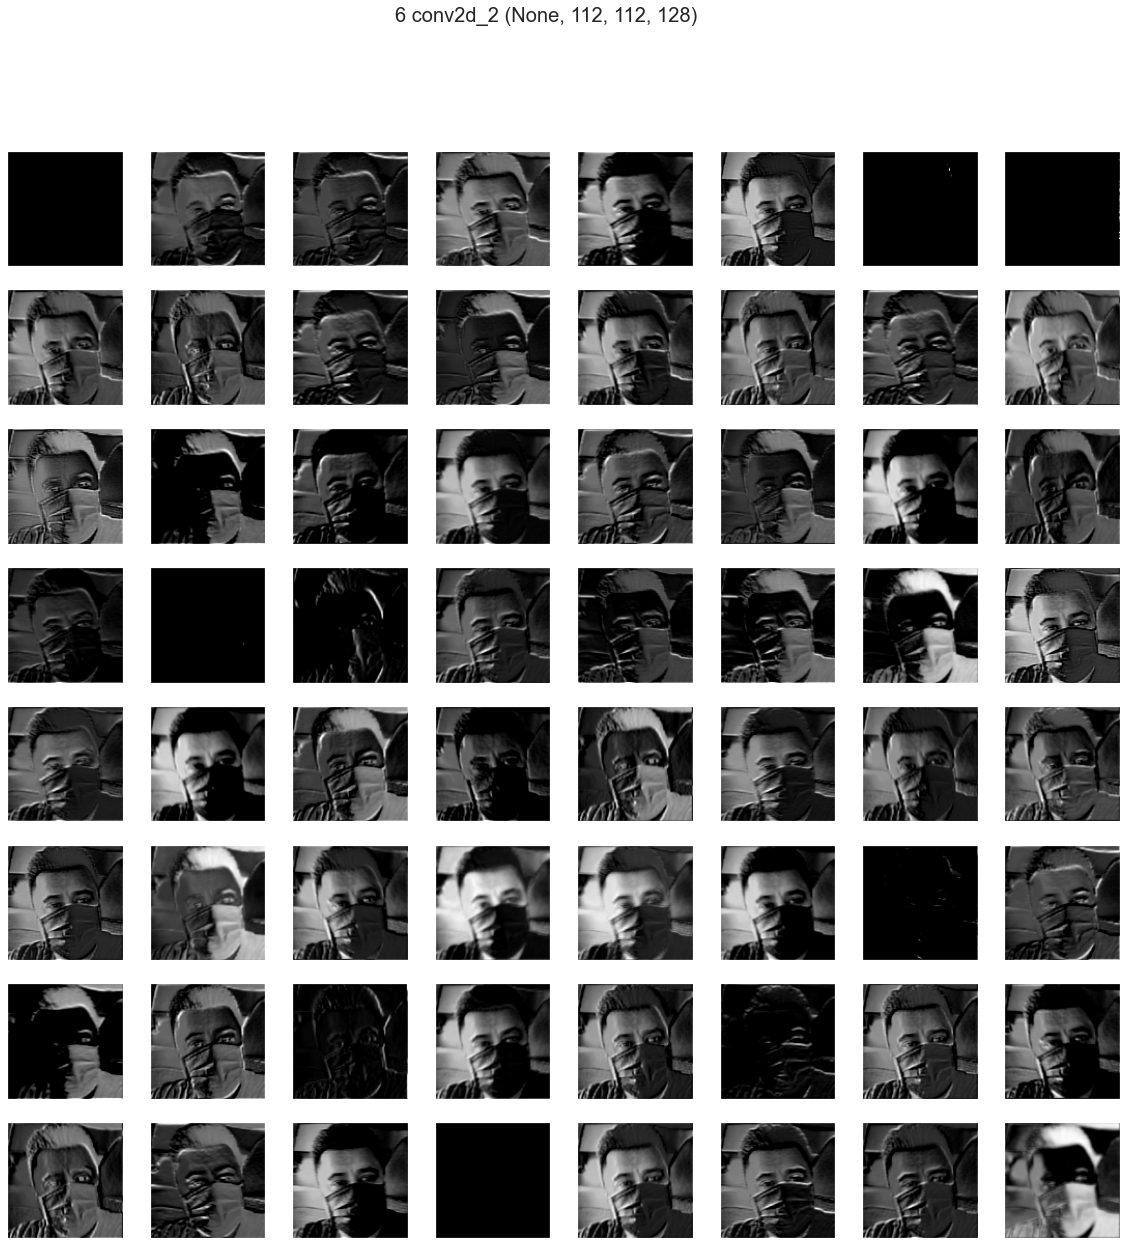

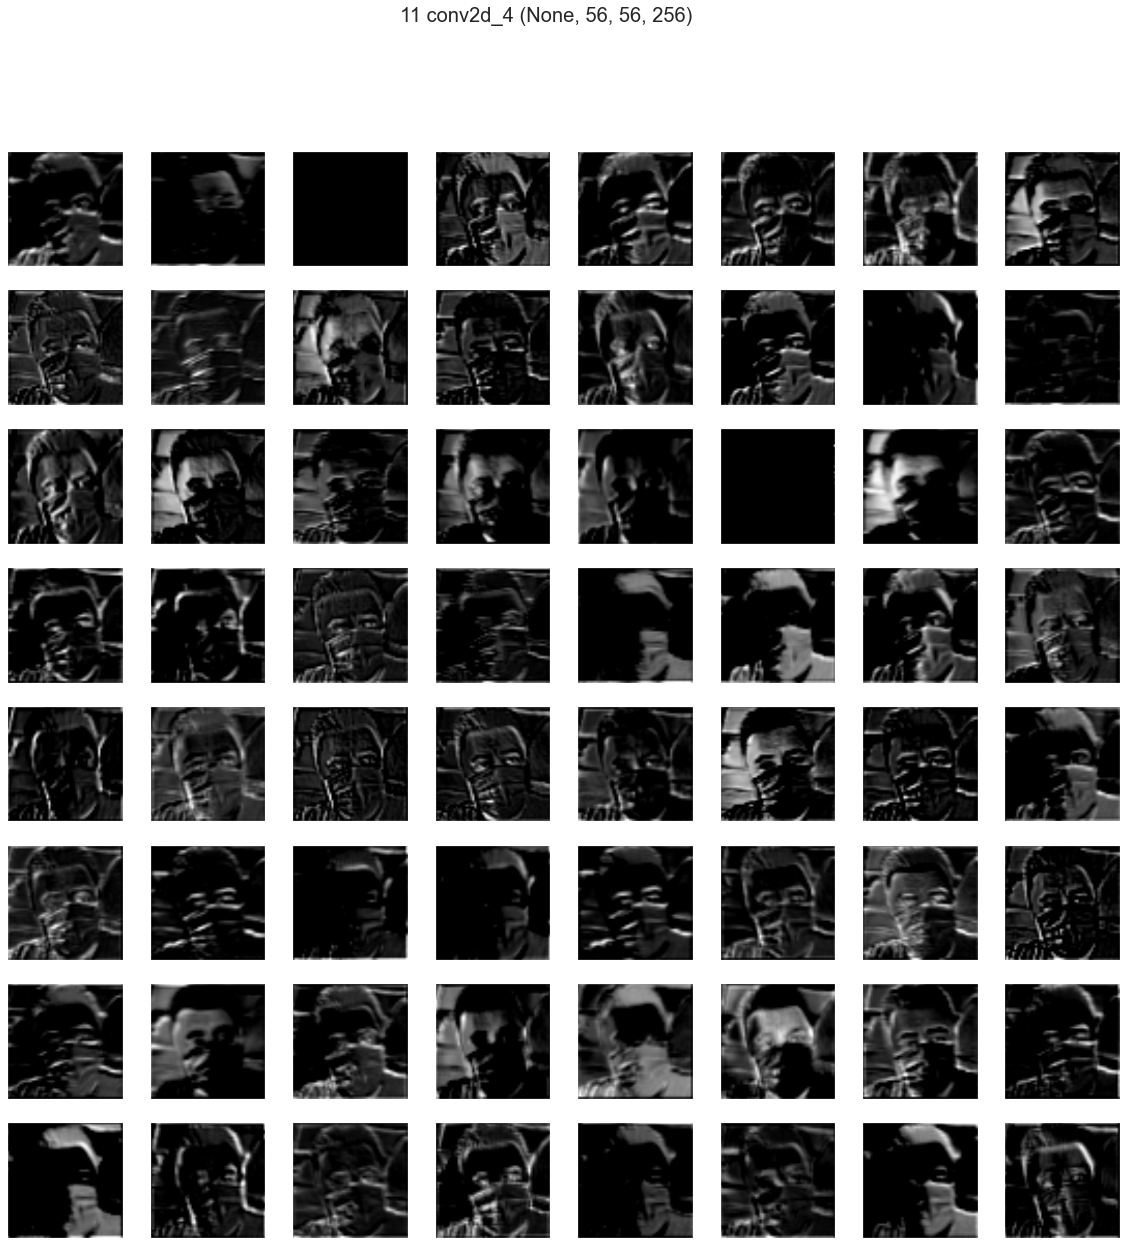

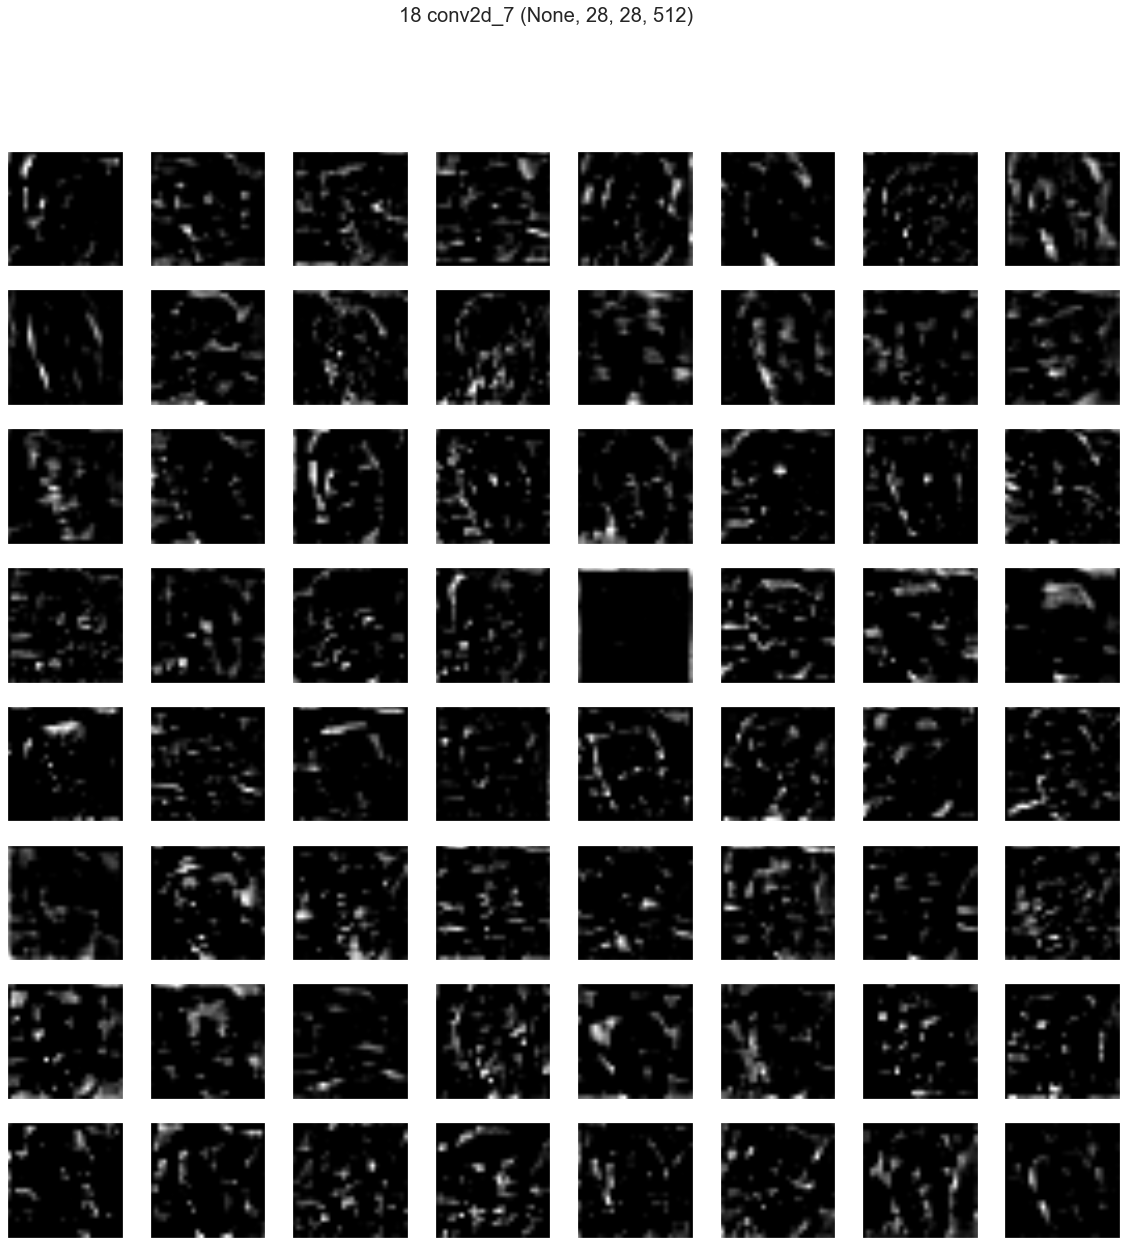

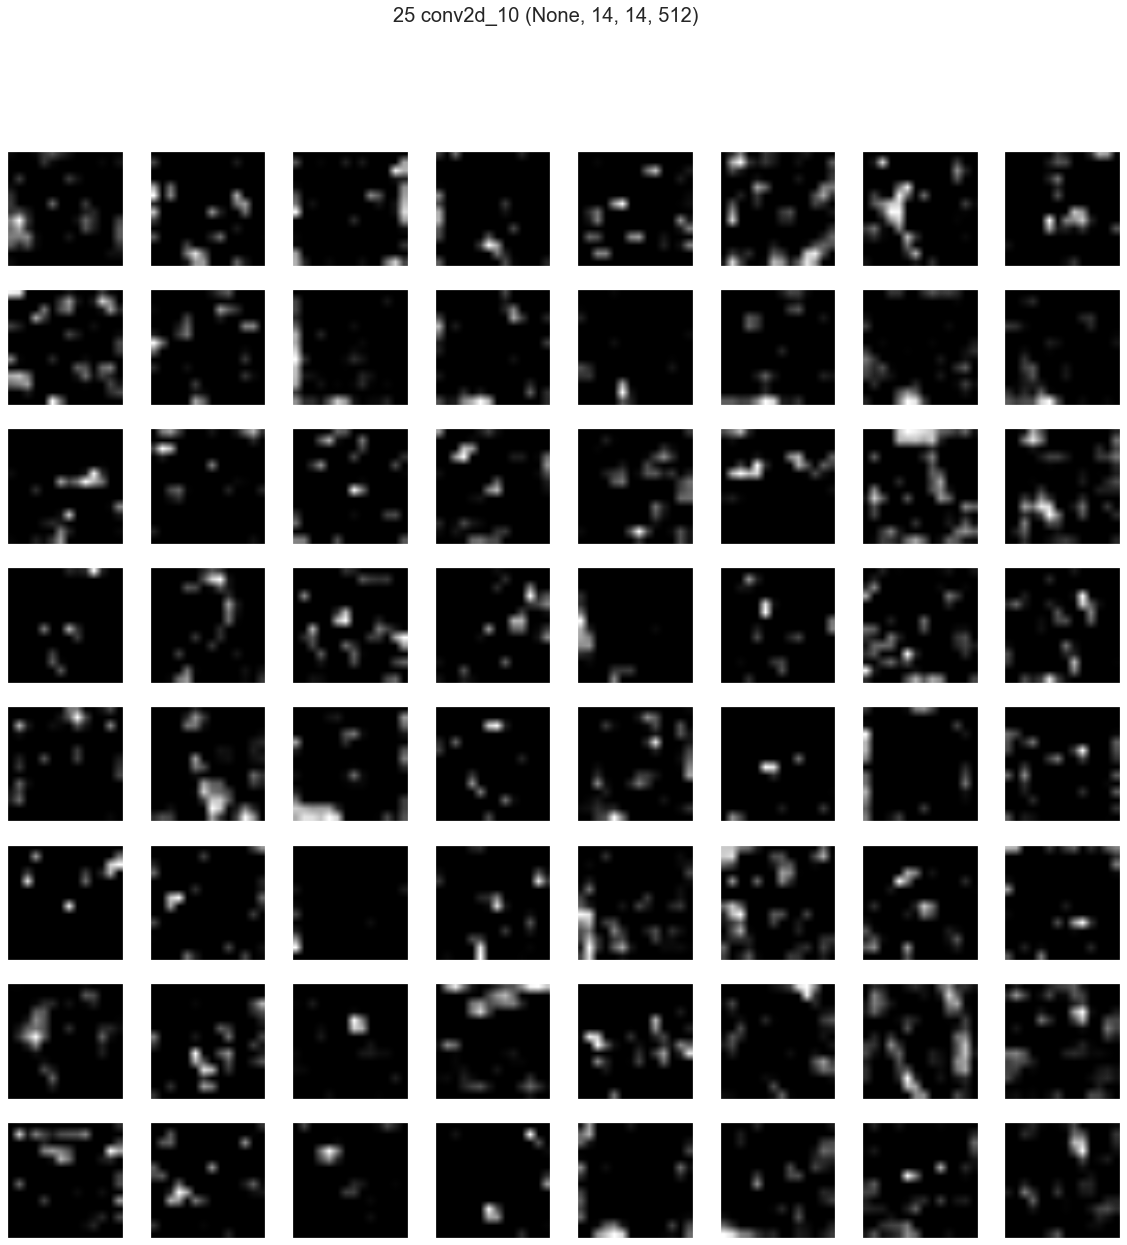

In [106]:
# plot the output from each block
square = 8
for fmap, block in zip(feature_maps, blocks):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    fig = plt.figure(figsize = (20,20))
    fig.suptitle(f'{block} {model.layers[block].name} {model.layers[block].output.shape}')
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray', interpolation='bilinear')
            ix += 1
    # show the figure
    pyplot.show()

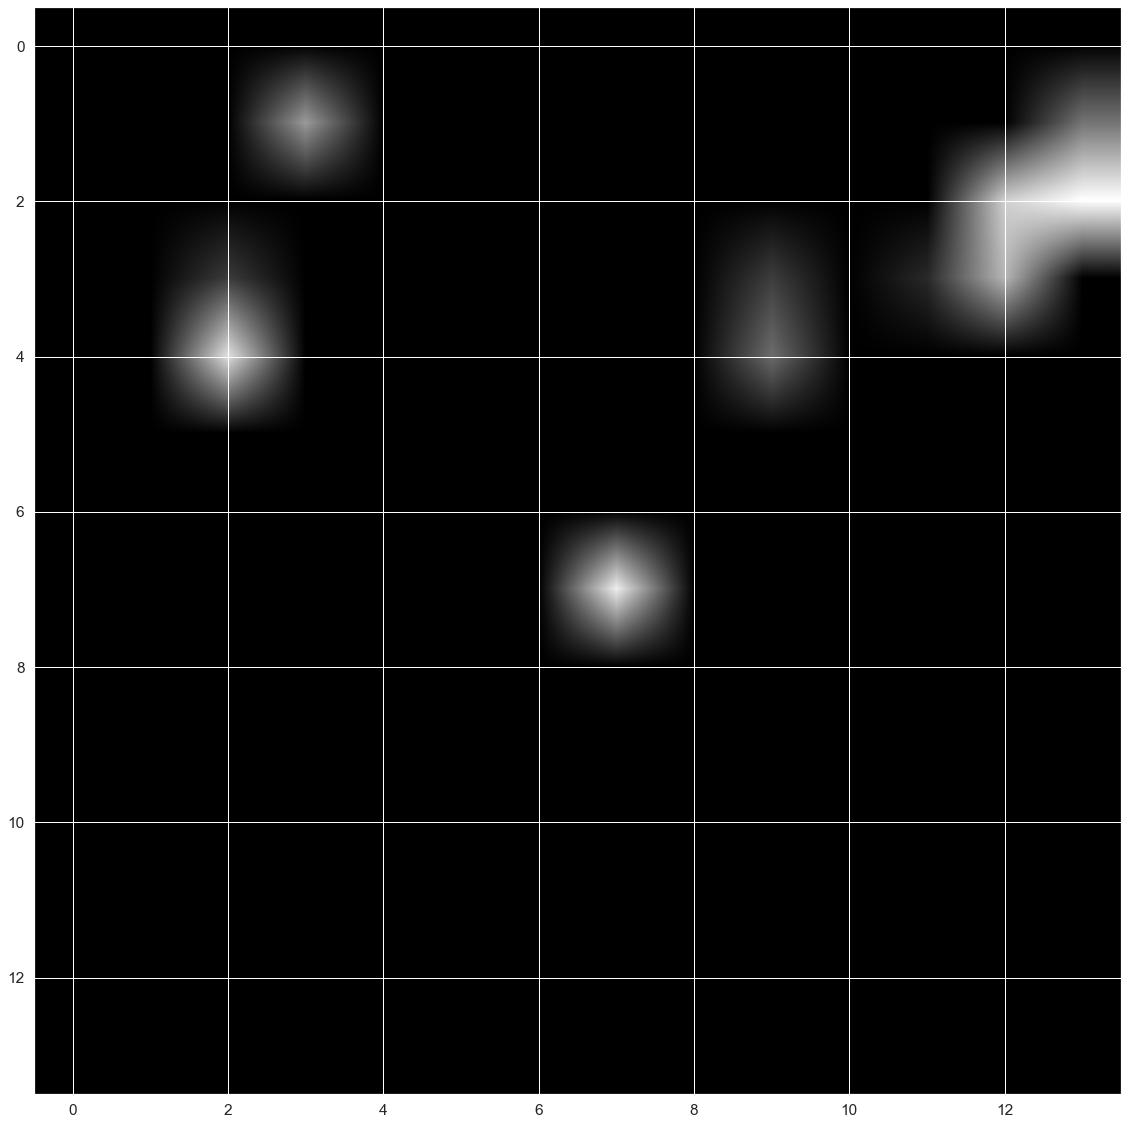

In [127]:
fig = plt.figure(figsize = (20,20))
pyplot.imshow(feature_maps[-2][0, :, :, 40], cmap='gray', interpolation='bilinear')

In [216]:
img_layer=Image.fromarray(feature_maps[-2][0, :, :, 2641], 'L').resize((224,224))
img_color_array = np.repeat(np.squeeze(img_to_array(img_layer))[:, :, np.newaxis], 3, axis=2)

IndexError: index 2641 is out of bounds for axis 3 with size 512

In [247]:
import cv2
img=load_img(original_paths[2], target_size=(224,224))
array = img_to_array(img)

In [248]:
cv2.bitwise_or(np.squeeze(img_color_array.reshape(1,-1)), np.squeeze(array.reshape(1,-1)))

array([[202.],
       [167.],
       [145.],
       ...,
       [ 58.],
       [ 52.],
       [ 62.]], dtype=float32)

In [161]:
np.squeeze(img_color_array.reshape(1,-1))

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [241]:
gray1 = cv2.cvtColor(array, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img_color_array, cv2.COLOR_BGR2GRAY)

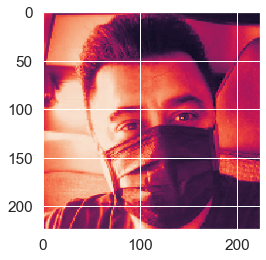

In [242]:
pyplot.imshow(gray1)

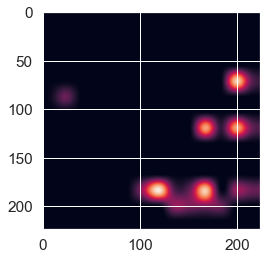

In [243]:
pyplot.imshow(gray2)

In [244]:
(gray2[::] > 0).shape, gray1.shape

((224, 224), (224, 224))

In [245]:
gray1[gray2[::] > 30] = 255

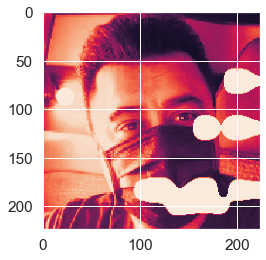

In [246]:
pyplot.imshow(gray1)